In [ ]:
from google.colab import files
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import html5lib
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

#Read in all NHL transactions and filter for trades only
#df=pd.read_csv("Hockey_trades_final.csv")

In [ ]:
import io
import requests
url="https://raw.githubusercontent.com/d141/590FP/main/Hockey_trades_final.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

# Build Networks

In [ ]:
#Current NHL teams
teams = {"Ducks":{},
"Coyotes":{},
"Bruins":{},
"Sabres":{},
"Flames":{},
"Hurricanes":{},
"Blackhawks":{},
"Avalanche":{},
"BlueJackets":{},
"Stars":{},
"RedWings":{},
"Oilers":{},
"Panthers":{},
"Kings":{},
"Wild":{},
"Canadiens":{},
"Predators":{},
"Devils":{},
"Islanders":{},
"Rangers":{},
"Senators":{},
"Flyers":{},
"Penguins":{},
"Sharks":{},
"Blues":{},
"Lightning":{},
"MapleLeafs":{},
"Canucks":{},
"GoldenKnights":{},
"Capitals":{},
"Jets":{},
                }

In [ ]:
#TODO
#Fix space formating in column 4 xxxx
#Fix data for teams that have moved or changed names xxx
#Split the date columns xxxx
#Variable for players sent/received xxxx

In [ ]:
df.tail()

,Unnamed: 0,Team A,Asset Sent,Asset Received,Team B,Num Players Sent,Num Player Received,Year,Month,Day
8359,12539,Jets,• Jordie Benn,• 2021 sixth round pick (?-?),Canucks,1,1,2021,4,12
8360,12540,Blackhawks,• 2021 fourth round pick (?-?),• Madison Bowey• 2021 fifth round pick (?-?),Canucks,2,1,2021,4,12
8361,12541,Canucks,• Madison Bowey• 2021 fifth round pick (?-?),• 2021 fourth round pick (?-?),Blackhawks,1,2,2021,4,12
8362,12542,Capitals,• Anthony Mantha,• Jakub Vrana• Richard Panik• 2021 first roun...,RedWings,4,1,2021,4,12
8363,12543,RedWings,• Jakub Vrana• Richard Panik• 2021 first roun...,• Anthony Mantha,Capitals,1,4,2021,4,12


In [ ]:
#Build nested dictionary of teams and their trade partners

network_dict = {}

for index, row in df.iterrows():

  #Figure out what season we're in
  year = row['Year']
  if row['Month'] < 7:
    season = f"{year-1} - {year}"
  else:
    season = f"{year} - {year + 1}"
  
  #Loop through teams dictionary and starting finding team A and team B
  a = row["Team A"]
  for team in teams.keys():
    if team in row["Team B"]:
      b=team
      
      '''
      if b=="Senators" or a=="Senators":
        if year < 1992:
          continue
      '''

      if a not in teams.keys():
        continue

      if season not in teams[a].keys():
        teams[a][season]={}
      
      if season not in network_dict.keys():
        network_dict[season] = {}

      if a not in network_dict[season].keys():
        network_dict[season][a] = {}

      if b not in teams[a][season].keys():
        teams[a][season][b] = 1
      else:
        teams[a][season][b] += 1

      if b not in network_dict[season][a].keys():
        network_dict[season][a][b] = 1
      else:
        network_dict[season][a][b] += 1

      try:  
        network_dict[season][a]['net_players'] +=  row['Num Player Received'] - row['Num Players Sent']
      except:
        network_dict[season][a]['net_players'] =  row['Num Player Received'] - row['Num Players Sent']

      try:  
        network_dict[season][b]['net_players'] +=  row['Num Players Sent'] - row['Num Player Received']
      except:
        try:
          network_dict[season][b]['net_players'] =  row['Num Players Sent'] - row['Num Player Received']
        except:
          network_dict[season][b] = {}
          network_dict[season][b]['net_players'] =  row['Num Players Sent'] - row['Num Player Received']



#For some reason the csv indicated that a team had traded with itself. Remove these
for team in teams:
  if team in teams[team].keys():
    teams[team].pop(team, None)



In [ ]:
network_dict['2000 - 2001']["Bruins"]['net_players']

-4

In [ ]:
#Construct the graph
#Edge weights correspond to number of transactions

networks_by_year = {}
year=2000
for i in range(10):
  season_string=f"{year + i} - {year + 1 + i}"

  G = nx.Graph()

  for team in teams.keys():

    G.add_node(team)

  for team_A in network_dict[season_string].keys():
    for team_B in network_dict[season_string][team_A].keys():
      G.add_edge(team_A, team_B, weight=network_dict[season_string][team_A][team_B])
  G.remove_nodes_from(list(nx.isolates(G)))
  G.remove_nodes_from(['net_players'])
  for node in G.nodes:
    try:
      G.nodes[node]['net_players'] = network_dict[season_string][node]['net_players']
    except:
      print(node, season_string)
  networks_by_year[season_string] = G

# Viz Scripts

In [ ]:
'''
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(36, 36)
ax = axes.flatten()

i=0
for network in networks_by_year:
  d = dict(networks_by_year[network].degree)

  pos = nx.spring_layout(networks_by_year[network])
  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()
  nx.draw(networks_by_year[network],ax=ax[i], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)
  ax[i].set_axis_off()
  ax[i].set_title(network)
  i+=1

plt.savefig('nhl_networks_10-20.png')
'''

In [ ]:
'''
plt.figure(figsize=(7,7))
 
for network in networks_by_year: 

  d = dict(networks_by_year[network].degree)
  weights = nx.get_edge_attributes(networks_by_year[network],'weight').values()

  nx.draw(networks_by_year[network], nodelist=d.keys(), width=[weight for weight in weights], node_size=[v+2 * 100 for v in d.values()], with_labels=True,font_color='k',font_size=8)
plt.show()
'''

In [ ]:
'''

import math
i,j=0,0
PLOTS_PER_ROW = 5
fig, axs = plt.subplots(4,5, figsize=(20, 60))
for network in networks_by_year: 
    axs[i][j].scatter(df['target_col'], df[col], s=3)
    axs[i][j].set_ylabel(network)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.show()
'''

In [ ]:
'''

import nx_altair as nxa
import altair as alt
%matplotlib inline
import numpy as np

pos = nx.spring_layout(G)


east=[
"Bruins",	"Hurricanes",
"Sabres", "BlueJackets"
"RedWings", "Devils",
"Panthers", "Islanders",
"Canadiens", "Rangers",
"Senators",	 "Flyers",
"Lightning",	 "Penguins",
"MapleLeafs",	 "Capitals"]

# Add attributes to each node.
for n in G.nodes():
    G.nodes[n]['weight'] = np.random.randn()
    G.nodes[n]['name'] = np.random.randint(1000)
    if n in east:
      G.nodes[n]['conference'] = 'East'
    else:
      G.nodes[n]['conference'] = 'West'
    

# Add attributes to edge.    
for e in G.edges():
    G.edges[(e[0],e[1])]['weight'] = np.random.uniform(1, 10)

chart = nxa.draw_networkx(
    G=G,
    pos=pos,
    node_size=200,
    node_color='conference',
    cmap='viridis',
    width='weight',
    node_tooltip=['weight', 'name', 'conference']
)

# Get the node layer
edges = chart.layer[0]
nodes = chart.layer[1]

# Build a brush
brush = alt.selection_interval(encodings=['x', 'y'])
color = alt.Color('conference:N',  legend=None)

# Condition nodes based on brush
nodes = nodes.encode(
    fill=alt.condition(brush, color, alt.value('gray')),
).add_selection(
    brush
)

# Create a bar graph to show highlighted nodes.
bars = alt.Chart(nodes.data).mark_bar().encode(
    x=alt.X('count()', scale=alt.Scale(domain=(0,20))),
    y='conference',
    color='conference',
).transform_filter(
    brush
)

alt.vconcat(edges+nodes, bars)
'''

# Build Attributes

In [ ]:
networks_by_year

{'2000 - 2001': <networkx.classes.graph.Graph at 0x7f337dc22f90>,
 '2001 - 2002': <networkx.classes.graph.Graph at 0x7f337dd97690>,
 '2002 - 2003': <networkx.classes.graph.Graph at 0x7f337dd97090>,
 '2003 - 2004': <networkx.classes.graph.Graph at 0x7f337dd97110>,
 '2004 - 2005': <networkx.classes.graph.Graph at 0x7f337dd97890>,
 '2005 - 2006': <networkx.classes.graph.Graph at 0x7f337dd97590>,
 '2006 - 2007': <networkx.classes.graph.Graph at 0x7f337dd97990>,
 '2007 - 2008': <networkx.classes.graph.Graph at 0x7f337dd97a50>,
 '2008 - 2009': <networkx.classes.graph.Graph at 0x7f337dd97910>,
 '2009 - 2010': <networkx.classes.graph.Graph at 0x7f337dd97350>}

In [ ]:
#Conference, Division, and Division Color Group


atlantic = ["Rangers", "Flyers", "Devils", "Islanders", "Penguins"]
northeast = ["Bruins", "Sabres", "Canadiens", "Senators", "MapleLeafs"]
southeast = ["Hurricanes" ,"Jets", "Panthers", "Lightning", "Capitals"]
central = ["Blackhawks", "BlueJackets", "RedWings", "Predators", "Blues"]
northwest = ["Flames", "Avalanche", "Oilers", "Wild", "Canucks"]
pacific = ["Sharks", "Kings", "Coyotes", "Stars", "Ducks"]
# Add attributes to each node.
for year in networks_by_year:
  for n in networks_by_year[year].nodes():
      if n in atlantic:
        networks_by_year[year].nodes[n]['conference'] = 'East'
        networks_by_year[year].nodes[n]['division'] = 'Atlantic'
        networks_by_year[year].nodes[n]['color_group'] = 1
      elif n in northeast:
        networks_by_year[year].nodes[n]['conference'] = 'East'
        networks_by_year[year].nodes[n]['division'] = 'Northeast'
        networks_by_year[year].nodes[n]['color_group'] = 2
      elif n in southeast:
        networks_by_year[year].nodes[n]['conference'] = 'East'
        networks_by_year[year].nodes[n]['division'] = 'Southeast'
        networks_by_year[year].nodes[n]['color_group'] = 3
      elif n in central:
        networks_by_year[year].nodes[n]['conference'] = 'West'
        networks_by_year[year].nodes[n]['division'] = 'Central'
        networks_by_year[year].nodes[n]['color_group'] = 4
      elif n in northwest:
        networks_by_year[year].nodes[n]['conference'] = 'West'
        networks_by_year[year].nodes[n]['division'] = 'Northwest'
        networks_by_year[year].nodes[n]['color_group'] = 5
      elif n in pacific:
        networks_by_year[year].nodes[n]['conference'] = 'West'
        networks_by_year[year].nodes[n]['division'] = 'Pacific'
        networks_by_year[year].nodes[n]['color_group'] = 6


In [ ]:
#PageRank, B/T Centrality, Degree, Neighbor Degree

for year in networks_by_year:
  page_rank_dict = nx.pagerank(networks_by_year[year])
  betweenness = nx.betweenness_centrality(networks_by_year[year])
  neighbors_degree = nx.average_neighbor_degree(networks_by_year[year])
  for n in networks_by_year[year].nodes():
    networks_by_year[year].nodes[n]['page_rank'] = float(np.round(page_rank_dict[n], 3))
    networks_by_year[year].nodes[n]['betweenness'] = float(np.round(betweenness[n], 3))
    networks_by_year[year].nodes[n]['degree'] = float(np.round(networks_by_year[year].degree(n), 3))
    networks_by_year[year].nodes[n]['neighbor_degree'] = float(np.round(neighbors_degree[n], 3))

In [ ]:
networks_by_year['2000 - 2001']['Rangers']

AtlasView({'Blackhawks': {'weight': 1}, 'Hurricanes': {'weight': 1}, 'Predators': {'weight': 2}, 'BlueJackets': {'weight': 1}, 'Avalanche': {'weight': 1}, 'Stars': {'weight': 1}, 'Blues': {'weight': 1}, 'Flames': {'weight': 2}, 'Wild': {'weight': 1}, 'Sharks': {'weight': 2}, 'Senators': {'weight': 1}, 'Panthers': {'weight': 1}, 'Lightning': {'weight': 1}})

In [ ]:
networks_by_year['2000 - 2001'].nodes['Bruins']

{'betweenness': 0.014,
 'color_group': 2,
 'conference': 'East',
 'degree': 5.0,
 'division': 'Northeast',
 'neighbor_degree': 8.2,
 'net_players': -4,
 'page_rank': 0.028}

In [ ]:
import statistics
from scipy import stats


trade_sds = []

#Favorite Partner, Trades (Players In and Out), Strategy
for year in networks_by_year:
  for n in networks_by_year[year].nodes():
    neighbors = networks_by_year[year].neighbors(n)
    max_weight = 0
    favorite_partner = ""
    #same conference same division
    #same conference different division
    #different conference
    scsd = 0
    scdd = 0
    dc = 0
    for i in neighbors:
      weight = networks_by_year[year].edges[n,i]['weight']
      if networks_by_year[year].nodes[n]['conference'] != networks_by_year[year].nodes[i]['conference']:
        dc += weight
      elif networks_by_year[year].nodes[n]['conference'] == networks_by_year[year].nodes[i]['conference'] and networks_by_year[year].nodes[n]['division'] == networks_by_year[year].nodes[i]['division']:
        scsd += weight
      elif networks_by_year[year].nodes[n]['conference'] == networks_by_year[year].nodes[i]['conference'] and networks_by_year[year].nodes[n]['division'] != networks_by_year[year].nodes[i]['division']:
        scdd += weight
      if weight > max_weight:
        favorite_partner = i
        max_weight = weight
    networks_by_year[year].nodes[n]['favorite_partner'] = favorite_partner
    networks_by_year[year].nodes[n]['favorite_partner_weight'] = max_weight
    networks_by_year[year].nodes[n]['scsd'] = scsd
    networks_by_year[year].nodes[n]['scdd'] = scdd
    networks_by_year[year].nodes[n]['dc'] = dc
    #classify the strategy
    #standard deviation of types of trades < 1.5 is a balanced strategy. Otherwise the strategy is based on the weight of trades to each area of the league
    trades = [scsd, scdd, dc]
    std_dev = statistics.stdev(trades)
    net_players = networks_by_year[year].nodes[n]['net_players']
    if std_dev < 1.5:
      if net_players > 1:
        networks_by_year[year].nodes[n]['strategy'] = 'Unbiased Buyer'
      elif net_players < -1:
        networks_by_year[year].nodes[n]['strategy'] = 'Unbiased Seller'
      else:
        networks_by_year[year].nodes[n]['strategy'] = 'Balanced'
    else:
      if scsd > scdd and scsd > dc:
        if net_players > 1:
          networks_by_year[year].nodes[n]['strategy'] = 'Local Buyer'
        elif net_players < -1:
          networks_by_year[year].nodes[n]['strategy'] = 'Local Seller'
        else:
          networks_by_year[year].nodes[n]['strategy'] = 'Locally Balanced'
      elif scdd > scsd and scdd > dc:
        if net_players > 1:
          networks_by_year[year].nodes[n]['strategy'] = 'Regional Buyer'
        elif net_players < -1:
          networks_by_year[year].nodes[n]['strategy'] = 'Regional Seller'
        else:
          networks_by_year[year].nodes[n]['strategy'] = 'Regionally Balanced'
      elif dc > scdd and dc > scsd:
        if net_players > 1:
          networks_by_year[year].nodes[n]['strategy'] = 'National Buyer'
        elif net_players < -1:
          networks_by_year[year].nodes[n]['strategy'] = 'National Seller'
        else:
          networks_by_year[year].nodes[n]['strategy'] = 'Nationally Balanced'
      else:
        networks_by_year[year].nodes[n]['strategy'] = 'Strategy Not Determined'

# Make JSON

In [ ]:
#JSON Format for D3
from networkx.readwrite import json_graph
import json

for year in networks_by_year:
  data = json_graph.node_link_data(networks_by_year[year])
  with open(f"data_{year}.json", 'w') as fp:
    json.dump(data, fp)


In [ ]:
with open('data.json', 'w') as fp:
    json.dump(data, fp)



# Analyze

In [ ]:
filenames =['NHL_Team_Stats_00-10 - 00-01.csv',
            'NHL_Team_Stats_00-10 - 01-02.csv',
            'NHL_Team_Stats_00-10 - 02-03.csv',
            'NHL_Team_Stats_00-10 - 03-04.csv',
            'NHL_Team_Stats_00-10 - 05-06.csv',
            'NHL_Team_Stats_00-10 - 06-07.csv',
            'NHL_Team_Stats_00-10 - 07-08.csv',
            'NHL_Team_Stats_00-10 - 08-09.csv',
            'NHL_Team_Stats_00-10 - 09-10.csv',
            ]

stats_dfs = []
for filename in filenames:
  stats = pd.read_csv(filename)
  stats_dfs.append(stats)

In [ ]:
import matplotlib.pyplot as plt

team_names = networks_by_year['2000 - 2001'].nodes
for df in stats_dfs:

  for team in team_names:
      df.loc[df['Unnamed: 0'].str.contains(team), 'Unnamed: 0'] = team


  df.loc[df['Unnamed: 0'].str.contains('Detroit Red Wings'), 'Unnamed: 0'] = 'RedWings'
  df.loc[df['Unnamed: 0'].str.contains('Toronto Maple Leafs'), 'Unnamed: 0'] = 'MapleLeafs'
  df.loc[df['Unnamed: 0'].str.contains('Columbus Blue Jackets'), 'Unnamed: 0'] = 'BlueJackets'
  df.loc[df['Unnamed: 0'].str.contains('Atlanta Thrashers'), 'Unnamed: 0'] = 'Jets'
  df.loc[df['Unnamed: 0'].str.contains('Mighty Ducks'), 'Unnamed: 0'] = 'Ducks'

In [ ]:
stats_dfs[0].sample()

,Unnamed: 0,Rk,Conf Champ,League Champ,AvAge,GP,W,L,T,OL,PTS,PTS%,GF,GA,SRS,SOS,GF/G,GA/G,PP,PPO,PP%,PPA,PPOA,PK%,SH,SHA,PIM/G,oPIM/G,S,S%,SA,SV%,SO
20,Rangers,21.0,0.0,0.0,29.5,82,33,43,5,1,72,0.439,250,290,-0.53,-0.04,3.05,3.54,65,363,17.91,86,400,78.5,16,12,18.3,16.8,2345,10.7,2575,0.887,0


In [303]:
strategies = []
buyer_seller = []
ranking = []
pts = []
num_partners = []
regions = []
players = []
ages = []

winner_ages = []
winner_players = []
winner_regions = []
winner_strategies = []
winner_partners = []
winner_buyer_seller = []

page_ranks = []
betweennesses = []
winner_page_ranks = []
winner_bts = []

pks = []
pps = []
winner_pks = []
winner_pps = []


i=0
for network in networks_by_year:
  if network == '2004 - 2005':
    print('skipped the lockout year')
    continue
  for team in list(networks_by_year[network].nodes):


    rank = stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)].Rk
    champ = int(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['Conf Champ'])
    pk = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PK%'])
    pp = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PP%'])
    age = float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['AvAge'])
    try:
      ranking.append(int(rank))
      pks.append(pk)
      pps.append(pp)
      pts.append(float(stats_dfs[i].loc[stats_dfs[i]['Unnamed: 0'].str.contains(team)]['PTS%']))
      ages.append(age)
    except:
      print(f"{team} not found in rankings")
    
    try:
      strategy = str(networks_by_year[network].nodes[team]['strategy'])
      strategies.append(strategy)
      if 'Buyer' in strategy:
        buyer = 'Buyer'
        buyer_seller.append(buyer)
      elif 'Seller' in strategy:
        buyer = 'Seller'
        buyer_seller.append(buyer)
      else:
        buyer = 'No Preference'
        buyer_seller.append(buyer)

      if 'National' in strategy:
        region = 'National'
        regions.append(region)
      elif 'Regional' in strategy:
        region = 'Regional'
        regions.append(region)
      elif 'Local' in strategy:
        region = 'Local'
        regions.append(region)
      else:
        region = 'No Preference'
        regions.append(region)

      num_partners.append(networks_by_year[network].nodes[team]['degree'])
      page_ranks.append(networks_by_year[network].nodes[team]['page_rank'])
      betweennesses.append(networks_by_year[network].nodes[team]['betweenness'])
      players.append(networks_by_year[network].nodes[team]['net_players'])

      if champ == 1:
        winner_strategies.append(networks_by_year[network].nodes[team]['strategy'])
        winner_regions.append(region)
        winner_partners.append(networks_by_year[network].nodes[team]['degree'])
        winner_buyer_seller.append(buyer)
        winner_page_ranks.append(networks_by_year[network].nodes[team]['page_rank'])
        winner_bts.append(networks_by_year[network].nodes[team]['betweenness'])
        winner_pks.append(pk)
        winner_pps.append(pp)
        winner_players.append(networks_by_year[network].nodes[team]['net_players'])
        winner_ages.append(age)
    except:
      print(f"{team} not found in {network} network")

  i += 1

skipped the lockout year


In [ ]:
len(strategies) == len(ranking) == len(pts) == len(num_partners) == len(buyer_seller)

True

In [ ]:
len(winner_partners) == len(winner_regions) == len(winner_strategies)

True

In [ ]:
'''
colors = {
    'National Buyer':,
    'National Seller':,
    'Nationally Balanced':,
    'Regional Buyer':,
    'Regional Seller':,
    'Regionally Balanced':,
    'Local Buyer':,
    'Local Seller':,
    'Locally Balanced':,
    'Unbiased Buyer':,
    'Unbiased Seller':,
    'Balanced':
}
'''

"\ncolors = {\n    'National Buyer':,\n    'National Seller':,\n    'Nationally Balanced':,\n    'Regional Buyer':,\n    'Regional Seller':,\n    'Regionally Balanced':,\n    'Local Buyer':,\n    'Local Seller':,\n    'Locally Balanced':,\n    'Unbiased Buyer':,\n    'Unbiased Seller':,\n    'Balanced':\n}\n"

In [ ]:
cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'turbo', 'nipy_spectral',
            'gist_ncar'])]

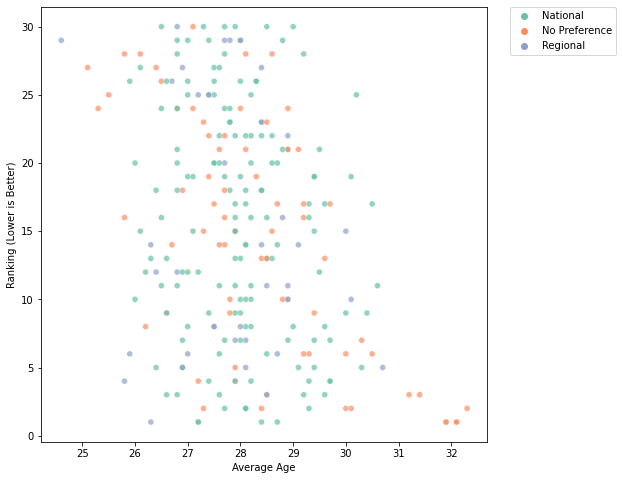

In [320]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set_palette("Set2", 8)
sns.scatterplot(x=ages, y=ranking, alpha=.7, hue=regions)
plt.xlabel("Average Age")
plt.ylabel("Ranking (Lower is Better)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

No handles with labels found to put in legend.


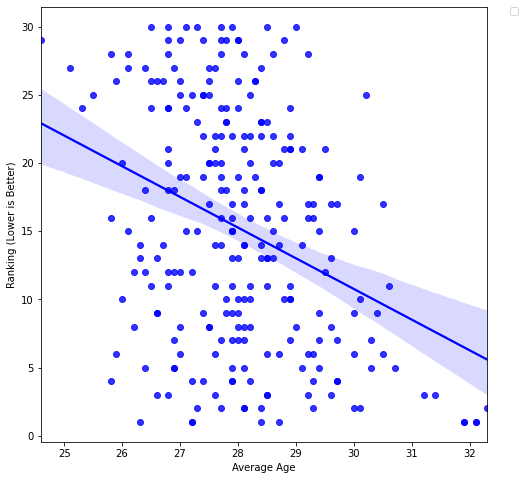

In [313]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set_palette("Set2", 8)
sns.regplot(x=ages, y=ranking, color='b')
plt.xlabel("Average Age")
plt.ylabel("Ranking (Lower is Better)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

(array([149.,   0.,   0.,   0.,  69.,   0.,   0.,   0.,  38.]),
 array([0.        , 0.22222222, 0.44444444, 0.66666667, 0.88888889,
        1.11111111, 1.33333333, 1.55555556, 1.77777778, 2.        ]),
 <a list of 9 Patch objects>)

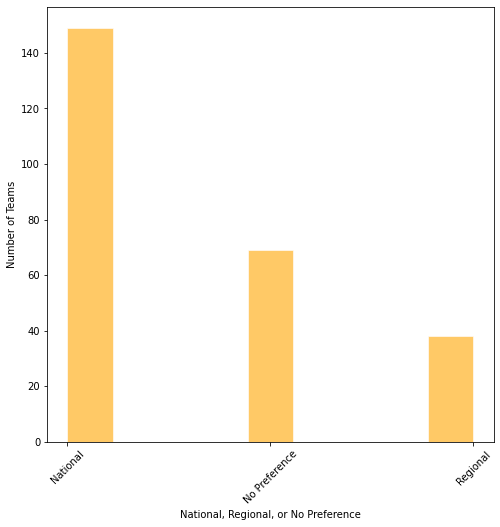

In [ ]:
?plt.figure(figsize=(8,8))
plt.xticks(rotation = 45)
plt.ylabel('Number of Teams')
plt.xlabel('National, Regional, or No Pref')
plt.hist(regions, edgecolor='white', bins=9, color='orange', alpha=.6)

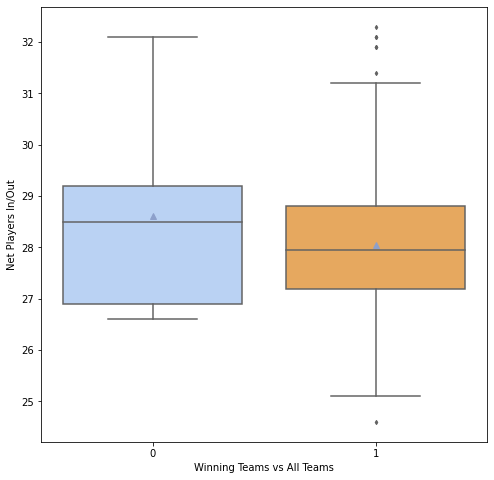

In [304]:
plt.figure(figsize=(8,8))
plt.ylabel('Net Players In/Out')
plt.xlabel('Winning Teams vs All Teams')
sns.boxplot(
    data=[winner_ages, ages],
    palette=[sns.xkcd_rgb["powder blue"], sns.xkcd_rgb["light orange"]],
    showmeans=True,
    fliersize=3
)